# Big Data for Biologists: Decoding Genomic Function- Class 11  

## How are genes regulated? Transcription factors and regulatory elements

##  Learning Objectives
***Students should be able to***

### How to represent a transcription factor's binding motif and scan sequences for matches 

<ol> 
    <li>  <a href=#TFMotif>Explain what transcription factors and transcription factor binding motifs are</a> </li>
 <li> <a  href=#PWM>Construct a position weight matrix (PWM) for a transcription factor by analyzing known transcription factor binding sequences </a></li>
 <li> <a href=#PSSM>Make a position-specific score matrices (PSSM) from a PWM to use for transcription factor motif-scanning  </a></li>
    <li><a href=#Scan>Motif scanning along a DNA sequence </a></li>
 <li> <a href=#Biopython>Become familiar with Biopython functions and modules: Align, Motif</a> </li>
 <li> <a href=#ChIPseq>Understand what is a ChIP-seq experiment and how it can be used to identify transcription factor binding genome-wide</a> </li>
 <li> <a href=#ChipseqBrowser>Visualize transcription factor ChIP-seq experiment in the WashU Genome Browser</a> </li>
</ol>

We have concluded our analysis of RNA-seq data. 

We will now transition to discussing the mehanisms that regulate gene expression.

We will begin by examining transcription factors, proteins that control the rate of gene expression.  


In [1]:
## We import our usual set of helper functions: 
import sys
sys.path.append('../helpers')
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from viz_sequence import * 

## What is a transcription factor?<a name='TFmotif' />

In molecular biology, <b>a transcription factor (TF) (or sequence-specific DNA-binding factor) is a protein that controls the rate of transcription of genetic information from DNA to messenger RNA, by binding to a specific DNA sequence</b>. Their function is to regulate - turn on and off - genes in order to make sure that they are expressed in the right cell at the right time and in the right amount throughout the life of the cell and the organism. Groups of TF's function in a coordinated fashion to direct cell division, cell growth, and cell death throughout life; cell migration and organization (body plan) during embryonic development; and intermittently in response to signals from outside the cell, such as a hormone. There are up to 2600 TFs in the human genome.

TFs work alone or with other proteins in a complex, by promoting (as an <b>activator</b>), or blocking (as a <b>repressor</b>) the <b>recruitment of RNA polymerase</b> (the enzyme that performs the transcription of genetic information from DNA to RNA) to specific genes.

A defining feature of TFs is that they contain at least one <b>DNA-binding domain (DBD), which has affinity to specific DNA short subsequences (~4-20 bp) collectively represented as a binding motif (pattern)</b>. TFs are grouped into classes based on their DBDs. Other proteins such as coactivators, chromatin remodelers, histone acetyltransferases, histone deacetylases, kinases, and methylases are also essential to gene regulation, but lack DNA-binding domains, and therefore are not TFs.

TFs are of interest in medicine because TF mutations can cause specific diseases, and medications can be potentially targeted toward them.

(Adapted from <a href="https://en.wikipedia.org/wiki/Transcription_factor">https://en.wikipedia.org/wiki/Transcription_factor</a>)

## What is a transcription factor binding motif?<a name='TFMotif' />

![Transcription factor binds to DNA motif](../Images/10_tf_motif.png)

Each transcription factor (TF) has strong chemical binding affinity to some short DNA sequences and weaker affinity to others. Hence, the motif of a TF is not a single deterministic sequence. Instead, you should think of the binding motif of a TF as a collection of all possible subsequences (possibly of variable length), each of which has a different affinity score i.e. a distribution of affinity scores. This is clearly a clunky representation of a motif i.e. a very long list of subsequences with associated affinity scores. Can we develop a compact representation of a binding motif that faithfully summarizes the variable affinity of the TF to different subsequences.

Let us assume we were able to conduct a sequencing experiment in some cell type, that provided us a sample of subsequences in the genome to which a TF binds.

For example, we have found that the GATA transcription factor binds to the following 4 sequences:



In [2]:
#tf_binding_sequences.fa is a file with known sequences that bind to the GATA transcription factor
sequences=open("tf_binding_sequences.fa",'r').read().strip().split('\n')
sequences 

['>sequence1',
 'TTGGATAA',
 '>sequence2',
 'CGATAACCG',
 '>sequence3',
 'CGATAT',
 '>sequence4',
 'AAAGGATAT']

## Construct a transcription factor binding motif representation called a position weight matrix (PWM)<a name='PWM' />  

We are given a collection of binding instances (subsequences) in the genome to which the TF binds and we want to derive a compact representation of the TFs binding motif.

The main principles behind deriving a motif representation is as follows
1. The subsequences that a TF likes to bind to (high affinity) are typically quite similar with some mismatches, insertions and deletions (remember alignments?)
2. The frequency of a subsequence in the collection of binding instances is proportional to the affinity of the TF to that subsequence i.e. If a TF has high affinity to a specific subsequence, that subsequence will be found more often in the collection of binding instances.

Based on these two principles, deriving a compact representation of a motif involves
1. Using multiple sequence alignment to align all the binding instance subsequences (which could be of variable length) allowing for mismatches, insertions and deletions
2. Counting frequencies of aligned subsequences, which can alternatively be recorded as counting frequencies of each type of nucleotide (A,C,G,T) at each position across all the aligned subsequences.

## From Multiple Sequence Alignment to PWM <a name='PWM' />

We use the [MUSCLE algorithm](http://www.ebi.ac.uk/Tools/msa/muscle/) to perform multiple sequence alignment and generate a consensus sequence. Refer to Tutorial 5 to refresh your knowledge of multiple sequence alignment.

In [3]:
#We use the MUSCLE algorithm to perform multiple sequence alignment and generate a consensus sequence.
from Bio.Align.Applications import MuscleCommandline
muscle_cline = MuscleCommandline(input="tf_binding_sequences.fa",fastaout='tf_binding_sequences_out.afa')
muscle_cline()

('',
 '\nMUSCLE v3.8.31 by Robert C. Edgar\n\nhttp://www.drive5.com/muscle\nThis software is donated to the public domain.\nPlease cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.\n\ntf_binding_sequences 4 seqs, max length 9, avg  length 8\n00:00:00    10 MB(-1%)  Iter   1   10.00%  K-mer dist pass 1\n00:00:00    10 MB(-1%)  Iter   1  100.00%  K-mer dist pass 1\n00:00:00    10 MB(-1%)  Iter   1   10.00%  K-mer dist pass 2\n00:00:00    10 MB(-1%)  Iter   1  100.00%  K-mer dist pass 2\n00:00:00    10 MB(-1%)  Iter   1   33.33%  Align node       \n00:00:00    11 MB(-1%)  Iter   1   66.67%  Align node\n00:00:00    11 MB(-1%)  Iter   1  100.00%  Align node\n00:00:00    11 MB(-1%)  Iter   1  100.00%  Align node\n00:00:00    11 MB(-1%)  Iter   1   25.00%  Root alignment\n00:00:00    11 MB(-1%)  Iter   1   50.00%  Root alignment\n00:00:00    11 MB(-1%)  Iter   1   75.00%  Root alignment\n00:00:00    11 MB(-1%)  Iter   1  100.00%  Root alignment\n00:00:00    11 MB(-1%)  Iter   1  100.00%  Ro

In [4]:
#Write a line of code to view the output of the alignment
###BEGIN SOLUTION
!cat tf_binding_sequences_out.afa
###END SOLUTION

>sequence1
-TTGGATAA---
>sequence2
---CGATAACCG
>sequence3
---CGATAT---
>sequence4
AAAGGATAT---


#### We examine the aligned portions of the sequences using the AlignIO module:

In [5]:
#The BioPython module AlignIO is an interface for inputing and outputing sequence alignments
#We use it here to view a formated alignment
import io 
from Bio import AlignIO
align = AlignIO.read("tf_binding_sequences_out.afa","fasta")
print("aligned sequences:")
print(align)

aligned sequences:
SingleLetterAlphabet() alignment with 4 rows and 12 columns
-TTGGATAA--- sequence1
---CGATAACCG sequence2
---CGATAT--- sequence3
AAAGGATAT--- sequence4


In [6]:
print(type(align))
align.__dict__

<class 'Bio.Align.MultipleSeqAlignment'>


{'_alphabet': SingleLetterAlphabet(),
 '_records': [SeqRecord(seq=Seq('-TTGGATAA---', SingleLetterAlphabet()), id='sequence1', name='sequence1', description='sequence1', dbxrefs=[]),
  SeqRecord(seq=Seq('---CGATAACCG', SingleLetterAlphabet()), id='sequence2', name='sequence2', description='sequence2', dbxrefs=[]),
  SeqRecord(seq=Seq('---CGATAT---', SingleLetterAlphabet()), id='sequence3', name='sequence3', description='sequence3', dbxrefs=[]),
  SeqRecord(seq=Seq('AAAGGATAT---', SingleLetterAlphabet()), id='sequence4', name='sequence4', description='sequence4', dbxrefs=[])],
 '_per_col_annotations': {},
 'annotations': {}}

#### We remove poorly aligned positions

In [7]:
#Remove the poorly aligned positions
sub_alignment=align[:,3:8]
print("\nalignment without poorly aligned positions:")
print(sub_alignment)


alignment without poorly aligned positions:
SingleLetterAlphabet() alignment with 4 rows and 5 columns
GGATA sequence1
CGATA sequence2
CGATA sequence3
GGATA sequence4


In [8]:
print(type(sub_alignment))
sub_alignment.__dict__

<class 'Bio.Align.MultipleSeqAlignment'>


{'_alphabet': SingleLetterAlphabet(),
 '_records': [SeqRecord(seq=Seq('GGATA', SingleLetterAlphabet()), id='sequence1', name='sequence1', description='sequence1', dbxrefs=[]),
  SeqRecord(seq=Seq('CGATA', SingleLetterAlphabet()), id='sequence2', name='sequence2', description='sequence2', dbxrefs=[]),
  SeqRecord(seq=Seq('CGATA', SingleLetterAlphabet()), id='sequence3', name='sequence3', description='sequence3', dbxrefs=[]),
  SeqRecord(seq=Seq('GGATA', SingleLetterAlphabet()), id='sequence4', name='sequence4', description='sequence4', dbxrefs=[])],
 '_per_col_annotations': {},
 'annotations': {}}

#### Now, we will record the frequencies of each nucleotide at each position in the aligned set of subsequences

One problem is that the raw counts (frequencies) of each nucleotide at each position would depend on the total number of subsequences sampled.

To avoid this dependence, we can instead <b>record proportions or probabilities (ranging from 0 to 1)</b> of observing each nucleotide at each position. i.e. we need to divide (<b>normalize</b>) the raw frequencies (counts) of each nucleotide at each position by the total number of subsequences. This representation of the binding motif of a TF is known as its <b>position weight matrix (PWM)</b>.

We notice that the first column contains base C twice, and base G twice. The second column always contains base G, and the third, fourth, and fifth columns always contain the bases A,T, and A, respectively. We can quantify this information with a position weight matrix (PWM). 

In [9]:
#We iterate through each sequence in our sub-alignment and extract only the .seq attribute
#This is the character string that encodes the DNA sequence from the alignment. 
aligned_sequences=[]
for seq in sub_alignment: 
    aligned_sequences.append(seq.seq)
print(aligned_sequences)

[Seq('GGATA', SingleLetterAlphabet()), Seq('CGATA', SingleLetterAlphabet()), Seq('CGATA', SingleLetterAlphabet()), Seq('GGATA', SingleLetterAlphabet())]


In [10]:
#The iteration above can be condensed into one line. 
#We iterate through each sequence a in our sub-alignment and extract the seq attribute
#This is the character string that encodes the DNA sequence from the alignment. 
aligned_sequences=[seq.seq for seq in sub_alignment]
print(aligned_sequences)

[Seq('GGATA', SingleLetterAlphabet()), Seq('CGATA', SingleLetterAlphabet()), Seq('CGATA', SingleLetterAlphabet()), Seq('GGATA', SingleLetterAlphabet())]


In [11]:
#We use the alphabet defined above to make a motif object.
from Bio import motifs
m = motifs.create(aligned_sequences)

In [12]:
#Print the consensus sequence for the motif 
m.consensus

Seq('CGATA')

In [13]:
#print the position weight matrix for the motif 
m.pwm

{'A': (0.0, 0.0, 1.0, 0.0, 1.0),
 'C': (0.5, 0.0, 0.0, 0.0, 0.0),
 'G': (0.5, 1.0, 0.0, 0.0, 0.0),
 'T': (0.0, 0.0, 0.0, 1.0, 0.0)}

[[0.  0.  1.  0.  1. ]
 [0.5 0.  0.  0.  0. ]
 [0.5 1.  0.  0.  0. ]
 [0.  0.  0.  1.  0. ]]


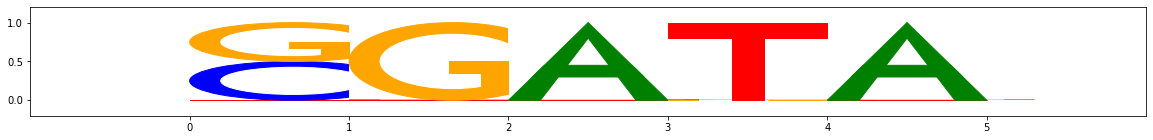

In [14]:
#convert the Pwm dictionary to an array and plot the PWM sequence logo 
import numpy as np 
pwm=np.asarray([m.pwm['A'],m.pwm['C'],m.pwm['G'],m.pwm['T']])
print(pwm)
plot_weights(pwm)

#### Question:
Why do the values of the rows in every column in the PWM sum to 1?

## Accounting for genomic background frequencies of nucleotides i.e. converting a PWM into a position specific scoring matrix (PSSM)<a name='PSSM' />

A PWM records the positional nucleotide probabilities based on an observed sample of binding instances (subsequences) from the genome. 

#### But what would these probabilities look like we just randomly sampled subsequences of the same length from the rest of the genome?

Imagine a genome that is very rich in Gs and Cs. Then if I randomly sampled subsequences from the genome, I would get high probabilities of Gs and Cs just by chance.

Hence, we need to <b>normalize</b> our PWM by these <b>random background probabilities</b> of nucleotides from the genome.

For simplicity, we assume that the bases A,C,G,T all occur with equal frequency (p=0.25). Note: this assumption rarely holds in reality! What you would actually do is count the total number of As, Cs, Gs and Ts in a particular genome and then divide by the size of the genome to obtain the background probabilities of each nucleotide.

In [ ]:
m.background

The normalized PWM, which we will call a <b>Position-specific scoring matrix</b> can be represented a log-odds matrix i.e. at each position 'i' for each nucleotide, we record the log2 of ratio of the probability in the PWM divided by the probability in the background.

We calculate the PSSM in accorance with the following formula:![PSSM formula](../Images/11_pssm_formula.png)

#### Unlike the PWM which has all values between 0 and 1 (probabilities), the PSSM can have positive or negative values in each position.

Positive values indicate a positive log odds i.e. greater chance of observing that nucleotide relative to background.

Negative values indicate a negative log odds i.e. lower chance of observing that nucleotide relative to background.

In [ ]:
m.pssm

We want to avoid the -inf values in our matrix, as mathematical operations break down for infinite values. To avoid this problem, we can add "pseudocounts" -- small numbers we add for each position in the PWM to avoid taking the log of 0. We add the pseudocounts to our "counts" matrix and recompute the PWM & PSSM. 

In [ ]:
#get the original pseudocounts, they should be 0 
print("Original pseudocounts:")
print(m.pseudocounts)

#Update the pseudocounts to 0.001 
m.pseudocounts['A']=0.001
m.pseudocounts['C']=0.001
m.pseudocounts['G']=0.001
m.pseudocounts['T']=0.001

print("Updated pseudocounts:")
print(m.pseudocounts)


In [ ]:
#Re-calculate the PSSM, we should no longer observe values if -inf 
pssm=m.pssm 
for base in ['A','C','G','T']: 
    pssm[base]=[round(val) for val in pssm[base]]
pssm

In [ ]:
#plot the PSSM 
pssm=np.asarray([pssm['A'],pssm['C'],pssm['G'],pssm['T']])
print(pssm)
plot_weights(pssm)

## The inverse problem: Scanning a DNA sequence with a PSSM to identify good matches i.e. likely binding instances<a name='Scan' />

The PSSM encodes the log odds of the probability of observing a specific nucleotide at each position across a collection of subsequences that a TF would bind to, relative to genomic background. 

Now, lets invert the problem.

#### We are given a PSSM of a TF (of length 'k') and we are given a long sequence (say an entire chromosome). We want to find all the positions in the long sequence that are strong matches to the PSSM i.e. positions to which the TF is likely to bind.

Formally, we can rephrase this statement as a concrete set of steps (an algorithm):

We are given a PWM of a TF (of length 'k') and we are given a long sequence (say an entire chromosome) (of length 'N'). 
1. We scan this DNA sequence, one position at a time (i = 1 to N)
2. At each position 'i', we obtain a subsequence of length 'k', starting at 'i' and ending at 'i+k-1'
3. We score this subsequence in terms of how good of a match it is to the PSSM
4. We decide some threshold on this score to decide if it is a good match to the PSSM or not
5. Positions that pass the threshold are good matches (likely binding sites) of the TF.

Steps (1) and (2) are obvious. 

### Computing the match score of a subsequence 

How do we perform Step (3) i.e. how do we obtain a match score for a sequence of length 'k' to a PSSM of length 'k'.

We simply sum the log odds scores of each of the nucleotides observed in the sequence at each position.

Lets say our sequence was CGATA and we wanted to score this sequence relative to the PSSM of length 5 we obtained above. 
Position 1 in the sequence is a C. Looking up the log odds of C (row 2) in position 1 (col 1) of the PSSM we get a score of 1

Position 2 in the sequence is a G. Looking up the log odds of G (row 3) in position 2 (col 2) of the PSSM we get a score of 2

Position 3 in the sequence is a A. Looking up the log odds of A (row 1) in position 3 (col 3) of the PSSM we get a score of 2

Position 4 in the sequence is a T. Looking up the log odds of A (row 1) in position 4 (col 4) of the PSSM we get a score of 2

Position 5 in the sequence is a A. Looking up the log odds of A (row 1) in position 5 (col 5) of the PSSM we get a score of 2

Match score = 1+2+2+2+2 = 9

This is a high positive score! Which means CGATA has a greater odds of matching the PWM than the background of the genome.

So CGATA must be a good match to the PSSM. If you visually cross check with the PWM or PSSM logo you will notice that CGATA is infact a good match.


#### Question: 

Calculate the score for CGGGG. Is it a good match to the PSSM?

## Motif scanning with Biopython <a name='Biopython' />

Going back to the five steps above, how can we write a program to scan a longer sequence with the PSSM to obtain a row of match scores for each position in the sequence? We have outlined the way an algorithm could work in the Appendix at the end of this class, but we will not be covering these steps in class. Biopython, however has a built-in functionality for motif scanning. To perform the motif scanning, we can simply run the following commands in Biopython: 

In [ ]:
from Bio.Seq import Seq
seq_object=Seq("NN"+sequence, m.alphabet)
for position, score in m.pssm.search(seq_object, threshold=-100):
    print("Position %d: score = %5.3f" % (position+1, score))

The negative positions refer to instances of the motif found on the reverse strand of the test sequence, and follow the Python convention on negative indices. You can also calculate the scores at all positions along the sequence: 

In [ ]:
m.pssm.calculate(seq_object)

In general, this is the fastest way to calculate PSSM scores. The scores returned by pssm.calculate are for the forward strand only. To obtain the scores on the reverse strand, you can take the reverse complement of the PSSM: 

In [ ]:
rpssm=m.pssm.reverse_complement()
rpssm.calculate(seq_object)

## How do we map genome-wide transcription factor binding using ChIP-seq experiments ? <a name='ChIPseq' />

ChIP-sequencing, also known as ChIP-seq, is a method used to analyze protein interactions with DNA. ChIP-seq combines a technique known as chromatin immunoprecipitation (ChIP) with massively parallel DNA sequencing to identify the binding sites of DNA-associated proteins. It can be used to map global binding sites precisely for any protein of interest.

ChIP is a powerful method to selectively enrich for DNA sequences bound by a particular protein in living cells. First, formaldehyde is used to cross-link (covalent bond) all proteins bound to DNA i.e. the proteins are not stuck to the DNA. The DNA is then sheared into tiny fragments, some of which are bound to the protein and most are not. An antibody targeting the protein is then used to pull down (enrich for) the fragments bound by the protein. This is called <b>chromatin immunoprecipitation (or ChIP)</b>. All the other DNA fragments are washed away. The protein is then unlinked from the bound DNA fragments and washed away.

Hence, the DNA obtained from ChIP is mainly enriched for bound DNA fragments. All the resulting ChIP-DNA fragments are sequenced simultaneously using a high-throughput sequencer.

The sequencing reads are then mapped to a reference genome using a short-read mapper such as Bowtie.

Regions with a large number of reads mapping to them are likely binding sites of the protein.

For any ChIP-seq experiment, a corresponding <b>control experiment</b> is performed, where the exact same procedure is followed as above except the antibody is not used to pull down the protein. So the DNA fragments in the control experiment are just sampled non-specifically from the genome. But this experiment allows us to observe any biases that may occur in terms of sampling reads at random. In fact, it has been observed that certain regions of the genome tend to be more easily sheared and sequenced than others. It is important to correct the ChIP-seq signal with the control to avoid false positives binding site positions.

In [15]:
from IPython.display import HTML
HTML('<iframe src="https://drive.google.com/file/d/0B_ssVVyXv8ZSSkhvVUlYc01zOGc/preview" width="1000" height="480"></iframe>')

/opt/conda/lib/python3.7/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")



We obtain four types of outputs from a ChIP-seq experiment

* <b>Genome-wide count coverage tracks for ChIP and control</b>: which counts the number of ChIP-fragments and control experiment fragments overlapping each position in the genome, respectively. 

* <b>A peaks track with statistically significant regions of signal enrichment</b>: To identify high confidence binding sites, the coverage track is then analyzed using a statistical model that compares the observed ChIP-seq read counts at each position to the control read counts at the same position (adjusted for differences in total number of reads).

* <b>Genome-wide normalized fold-enrichment coverage track</b>: which is similar to the count coverage track. But instead of raw counts at each position, it has the fold-enrichment of ChIP-seq counts relative to control counts


* <b>Genome-wide -log10(p-value) coverage track</b>: which is similar to the count coverage track. But instead of raw counts at each position, it has the -log10(p-value) of statistical significance of ChIP-seq counts relative to control counts


<b>Question:</b> If I had 10,000 sequencing reads from a ChIP-seq experiment and a genome of size 1000 bp, how many reads should I expect by chance if I uniformly scattered the reads along the genome?

The ChIP-seq signal at position in the genome is computed as the fold-enrichment i.e. ratio of observed ChIP-seq counts to control counts. This is also referred to as the *effect-size* of signal.

Further, we use a statistical null model (based on a count based random distribution called the Poisson distribution) to compute a *p-value* for the observed count at each position i.e. what is the probability that the counts >= the observed value could have just happened by chance.

We then use multiple hypothesis testing correction using the Benjamini Hochberg method to obtain adjusted *p*-values. We use a threshold e.g. 0.05 on the adjusted p-values to identify genomic locations with statistically significant signal. These are the likely binding sites of the transcription factor!

## Visualizing ChIP-seq data in the genome browser <a name='ChipseqBrowser' />

Lets visualize ChIP-seq data for a transcription factor called CTCF in a lymphoblastoid cell-line called GM12878.

WashU Epigenome browser session: http://epigenomegateway.wustl.edu/browser/?genome=hg19&session=ddNxKsyNNX&statusId=1299889156

## APPENDIX

### One-hot Encoding

Going back to the five steps above, how can we write a program to scan a longer sequence with the PSSM to obtain a row of match scores for each position in the sequence?

To do this efficiently, we will use a slightly different representation for the DNA sequence called a 'one-hot-encoding'.

<b>'One-hot-encoding'</b> is a process that transforms a sequence of nucleotides of length 'N' into a matrix of 1's and 0's with 4 rows (representing A,C,G and T) and 'N' columns (representing positions).

In the graphic below, a colored square represents a '1', indicating the presence of the specified nucleotide at that position along the sequence. A blank square represents a '0', indicating the absence of the specified base at the position. 
![one-hot-encoding](images/10_one_hot.png)

In [ ]:
#we write a function to perform one-hot encoding. 
def one_hot_encode(sequence): 
    encoding_dict=dict() 
    encoding_dict['A']=[1,0,0,0]
    encoding_dict['C']=[0,1,0,0]
    encoding_dict['G']=[0,0,1,0]
    encoding_dict['T']=[0,0,0,1]
    
    encoded_sequence=[] 
    for base in sequence: 
        encoded_sequence.append(encoding_dict[base])
    return np.array(encoded_sequence).transpose()

#We now one-hot encode a DNA sequence 
sequence="GCATTACCGATAA"
encoded_sequence=one_hot_encode(sequence)
encoded_sequence

### The inner product
We now scan the PSSM (length 5) across the entire sequence by aligning the PSSM with every subsequence of length 5 in the sequence starting at position and computing the match score as we did above.

Note that the match score for a subsequence is simply the sum of position-wise scores from the PSSM corresponding to each nucleotide in the subsequence.

An efficient command to obtain this match score of a subsequence aligned to a PSSM is an <b>inner product</b> of the PSSM matrix with the 1-hot encoded matrix of the aligned subsequence. 

An inner product is simply a sum of the element-by-element multiplication of the values in the two matrices i.e. the PSSM matrix (4 rows, 5 columns) and the one-hot encoded subsequence (4 rows, 5 columns).

An inner product is often represented mathematically as a < , > operator. E.g. if 'W' is the PSSM matrix and 'X' is the one-hot encoded subsequence, their inner-product is written as < W , X >

![Convolution product](../Images/10_convolution3.png)

#### Question:
Can you explain how the inner product of the PSSM and the one-hot encoded sequence is equivalent to the sum of position-wise scores from the PSSM corresponding to each nucleotide in the subsequence.


### Convolution operation

There is also a built in operation known as the <b>'convolution'</b> that can perform a scanning inner-product of one short matrix (PSSM) against a longer matrix (one-hot encoded longer sequence). The convolution directly outputs the match scores at each position in the sequence.

We can then simply restrict to positions with positive match scores (log-odds) as the positions that will be most likely bound by the TF.


![Convolution formula](../Images/10_optimal_convolution_product.png)


We can perfom the motif scan in Python by following the steps below:

In [ ]:
from scipy.signal import fftconvolve
def scan_sequence(sequence,pssm): 
    convolution_product=fftconvolve(sequence[::-1,::-1],pssm,mode="same")[::-1,::-1][1]
    #get the starting position of the motif along the sequence 
    starting_pos=np.argmax(convolution_product)-pssm.shape[1]/2
    return convolution_product,starting_pos

convolution_product,starting_pos=scan_sequence(encoded_sequence,pssm)
print("Convolution product:"+str(convolution_product))
print("Motif starting position along the sequence:"+str(starting_pos))